# Support Vector Machine

In [1]:
# file path exist
import os.path
from os import path

# translator
import googletrans
from googletrans import Translator

# pandas
import pandas as pd

# preprocessing of text
import re
import string


# word tokenizer by nltk
from nltk import word_tokenize

# lemmatizer
from nltk.stem import WordNetLemmatizer

# stopwords (Remove buzz words)
from nltk.corpus import stopwords

# split data into train and test
from sklearn.model_selection import train_test_split

# bag of words
from sklearn.feature_extraction.text import CountVectorizer

# TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer

# RFM classifier from scikit learn
from sklearn.svm import LinearSVC

# Tf-idf feature extraction 
from sklearn.feature_extraction.text import TfidfVectorizer

# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# cross validation for kfold
from sklearn.model_selection import cross_val_score

# calc accuracy
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

In [2]:

# original hindi file
filename  = 'Eng-Hin-data/hindi-anot-shuffled'
orig_df = pd.read_csv(filename + '.csv',  
               delimiter=',')
orig_df.columns = ['Text', 'Label']

In [3]:
orig_df.head()

,Text,Label
0,'गाजा में दीवाली की ढेरो बधाई मित्रो 😊💐 #Is...,2
1,'@SanjayGadhiaINC @IndiaToday18 अज़ाबे इलाही 👍,1
2,'आखिर अब #सुशांत_सिंह_राजपूत जी को न्याय मिल ज...,0
3,'अमीन के 500 से अधिक छात्रों ने सर्वे भवन के ग...,0
4,'@deoriapolice @Uppolice @myogiadityanath @spg...,0


In [4]:
orig_df["Text"] = orig_df["Text"].astype(str)
orig_df["Label"] = orig_df["Label"].astype(str)
df = orig_df

In [5]:
# Displaying eg tweet before translation
df.Text[6]

"'आज के दिन ही मेरा क्रिकेट प्रेम भी समाप्त हो गया"

### Class count

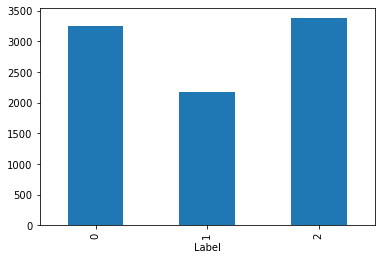

In [7]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [8]:
# For entire dataset sentences for each labels 
df.Label.value_counts()

2    3375
0    3244
1    2174
Name: Label, dtype: int64

In [9]:
#balancing data 
from collections import Counter
import numpy as np
def balanceClasses(xs, ys):
    item = {}
    new_ys = []
    new_xs = []
    #"""Undersample xs, ys to balance classes."""
    freqs = Counter(ys)
    # the most common class  is the maximum number we want for all classes
    max_allowable = (freqs.most_common()[0][1])
    
    for val in freqs.most_common(): # List
        nums = np.random.randint(1000)
        i = 1
        item[val[0]] = max_allowable - val[1]
        
        if item[val[0]] > 0:            
            while(item[val[0]] - i != 0): 
                nums = nums + 1
                if ys[nums] == val[0]:
                    i += 1
                    new_ys.append(ys[nums])
                    new_xs.append(xs[nums])
    return new_xs, new_ys

In [10]:
new_text, new_label = balanceClasses(df['Text'], df['Label'])

In [11]:
data = pd.DataFrame(new_text)
data.columns = ['Text']
data['Label'] = new_label
data = pd.concat([df, data])

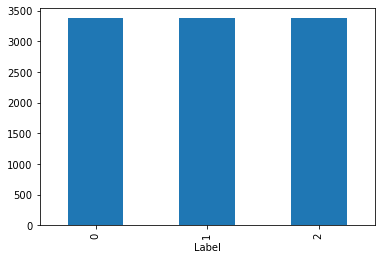

In [12]:
fig1 = plt.figure(figsize=(6,4))
data.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [13]:
data.Label.value_counts()

2    3375
0    3374
1    3374
Name: Label, dtype: int64

In [14]:
data=data.sample(frac=1).reset_index(drop=True)
data

,Text,Label
0,'🌙 🕋 आलम ए इस्लाम को 1442 हिजरी #इस्लामी नया स...,1
1,'Welcome या ख़ुदा डॉक्टर साहब की आवाज़ को हमेश...,1
2,'@Jindgiekjung शानदार जिन्दाबाद❗,0
3,'@Lalu17SP @yadavteju @Rajlakshmiyadav @spsuni...,0
4,'SSR Death Case: सुशांत सिंह राजपूत को न्याय द...,0
...,...,...
10118,'हज़रत इमाम हुसैन अलैहिस्सलाम फरमाते हैं: इज़्...,1
10119,'@himansh76886855 क्यों की जेहादी जेहादी को बच...,2
10120,'@DeepikaSRajawat अरे कोमरेड की पालतू क्या हुआ...,2
10121,'कट्टर जेहादी मानसिकता के धनी ओवैसी को ज्ञानी ...,2


### Data Preprocessing

In [15]:
# People usually join sentences using more than one colon 

def ReplaceDoubleColon(inputString):
    return inputString.replace("..", " ") 

data['Text'] = data['Text'].apply(lambda x: ReplaceDoubleColon(x))

def ReplaceTripleColon(inputString):
    return inputString.replace("...", " ") 

data['Text'] = data['Text'].apply(lambda x: ReplaceTripleColon(x))

def ReplaceFourColon(inputString):
    return inputString.replace("....", " ") 

data['Text'] = data['Text'].apply(lambda x: ReplaceFourColon(x))

In [16]:
def textPattern(text):

    # Clean the text
    text = re.sub(r"@", " ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\= =", " ", text)
    text = re.sub(r"\==", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

data['Text'] = data['Text'].apply(lambda x: textPattern(x))

In [17]:
# Word Tokenization
tokens = [word_tokenize(sen) for sen in data.Text]

In [18]:
# Lower Case
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens]

In [19]:
# Remove Link

def removeLink(token):
    word = []
    for w in token:
        if not w.startswith('http'):
            word.append(w)
    return word 
    
removedLink_tokens = [removeLink(token) for token in lower_tokens]

In [20]:
# Word Lemmatization
def lemmatization(token):
    return [lemmatizer.lemmatize(w) for w in token] 

lemmatizer = WordNetLemmatizer()

lemmatized_tokens = [lemmatization(token) for token in removedLink_tokens]

In [21]:
# Removing Stopwords
stoplist=open("Devanagari/stopwords.txt","r")

In [22]:
def removeStopWords(tokens): 
    return [word for word in tokens if word not in stoplist]

filtered_words = [sen for sen in lemmatized_tokens]
data['Text_Final'] = [' '.join(sen) for sen in filtered_words]
data['tokens'] = filtered_words

In [23]:
zero  = []
one = []
two = []
for l in data.Label:
    
    if l == '0':
        zero.append(1)
        one.append(0)
        two.append(0)
    elif l == '1':
        zero.append(0)
        one.append(1)
        two.append(0)
    elif l == '2':
        zero.append(0)
        one.append(0)
        two.append(1)
        
data['0']= zero
data['1']= one
data['2']= two

data = data[['Text_Final', 'tokens', 'Label', '0', '1', '2']]

In [24]:
category_id = []
for l in data.Label:
    
    if l == '0':
        category_id.append('0')
    elif l == '1':
        category_id.append('1')
    elif l == '2':
        category_id.append('2')
        
data['Category_id'] = category_id

data = data[['Text_Final', 'tokens', 'Label', '0', '1', '2', 'Category_id' ]]
data.head(25)

,Text_Final,tokens,Label,0,1,2,Category_id
0,🌙 🕋 आलम ए इस्लाम को 1442 हिजरी # इस्लामी नया स...,"[🌙, 🕋, आलम, ए, इस्लाम, को, 1442, हिजरी, #, इस्...",1,0,1,0,1
1,welcome या ख़ुदा डॉक्टर साहब की आवाज़ को हमेशा...,"[welcome, या, ख़ुदा, डॉक्टर, साहब, की, आवाज़, ...",1,0,1,0,1
2,jindgiekjung शानदार जिन्दाबाद❗,"[jindgiekjung, शानदार, जिन्दाबाद❗]",0,1,0,0,0
3,lalu17sp yadavteju rajlakshmiyadav spsunilyada...,"[lalu17sp, yadavteju, rajlakshmiyadav, spsunil...",0,1,0,0,0
4,ssr death case : सुशांत सिंह राजपूत को न्याय द...,"[ssr, death, case, :, सुशांत, सिंह, राजपूत, को...",0,1,0,0,0
5,आलम ए इस्लाम को इस्लामी नए साल 1442 हिजरी माहे...,"[आलम, ए, इस्लाम, को, इस्लामी, नए, साल, 1442, ह...",1,0,1,0,1
6,वो जिहादी होता तो आंसू निकलते,"[वो, जिहादी, होता, तो, आंसू, निकलते]",2,0,0,1,2
7,ekhivillain # banislam & amp # fuckislam बाकी ...,"[ekhivillain, #, banislam, &, amp, #, fuckisla...",2,0,0,1,2
8,rajsagarbsp_ somjee_p_bsp mayawati congratulat...,"[rajsagarbsp_, somjee_p_bsp, mayawati, congrat...",0,1,0,0,0
9,2014 से जीडीपी रुपए इकॉनमी गिरने से पीएम की सा...,"[2014, से, जीडीपी, रुपए, इकॉनमी, गिरने, से, पी...",0,1,0,0,0


In [25]:
data = data[data.tokens != '']

In [26]:
from io import StringIO
category_id_df = data[['Label', 'Category_id']].drop_duplicates().sort_values('Category_id')
category_to_label_dict = dict(category_id_df.values)
label_to_category_dict = dict(category_id_df[['Category_id', 'Label']].values)

#### Split Data into test and train
We will use 90 % data for training and 10 % for testing. We use random state so every time we get the same training and testing data.

# Support Vector Method (SVM) and Random Forest Method (RFM)

We referred a blog on Multi class classification for SVM and RFM [2]

### Generating features using TF-IDF Vectorizer method

In [27]:
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='latin-1', ngram_range=(1, 5), stop_words='english')
features = vectorizer.fit_transform(data.Text_Final).toarray()
labels = data.Label
features.shape

(10123, 32916)

### Testing SVM models using K-fold cross validation


In [48]:
import random

# Creating model 
model = LinearSVC()

# KFold cross-validation
kFold = 10

scores = []
#To get accuracy of the model for 10 different splits
scoreValue = cross_val_score(model, features, labels, scoring='accuracy', cv= kFold)

# append name and score of each model with different splits
print("Support Vector with Tf-idf: ")
for fold_idx, accuracy in enumerate(scoreValue):
    print ((fold_idx + 1), accuracy)
    scores.append(accuracy)
    
Mean_score =  sum(scores) / len(scores)
print(f" Average Accuracy : {Mean_score}" )


Support Vector with Tf-idf: 
1 0.9111549851924975
2 0.8953603158933859
3 0.8914116485686081
4 0.8942687747035574
5 0.8982213438735178
6 0.8685770750988142
7 0.9021739130434783
8 0.9051383399209486
9 0.9071146245059288
10 0.9100790513833992
 Average Accuracy : 0.8983500072184135


### Spliting data 90/ 10

In [29]:
# Using similar split as CNN model
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(features, labels, data.index, test_size=0.10, random_state=82)

### SVM - Generating model 

In [30]:
# generate Linear SVM model
model = LinearSVC()
clf = model.fit(X_train, y_train)
y_pred = model.predict(X_test)

### SVM - Showing some prediction

In [31]:
# 0
print(clf.predict(vectorizer.transform(["These media fellows have time to dissect one's social media profile,but none of spineless jokers has the guts to question as to why and how a convict like Lalu Yadav is roaming outside and running a Government."])))

['0']


In [32]:
# 2
print(clf.predict(vectorizer.transform(["Muslim asshole jehadi!"])))

['2']


In [33]:
# 1
print(clf.predict(vectorizer.transform(["I have a muslim friend and Islam is beautiful"])))

['2']


In [34]:
# 2
print(clf.predict(vectorizer.transform(["@Peer__Pressure_ @Totla_musa It's a religion of rape. Momo started it and it still continues to this day. Haven't you heard the saying what the right hand possess It's is from Pisslam "])))

['2']


In [35]:
#1
print(clf.predict(vectorizer.transform(["'@hiavol6 happy first day of muharram bub ily"])))

['1']


###  SVM - Displaying false-positive rate (FPR) and true positive rate (TPR)

                          Support Vector Method


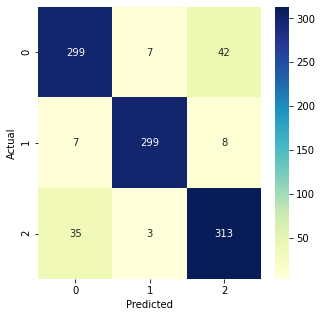

In [36]:
from sklearn.metrics import confusion_matrix
print("                          Support Vector Method")
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap ='YlGnBu',
            xticklabels=category_id_df.Label.values, yticklabels=category_id_df.Label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### SVM - Precision, Recall and F1-Score to quantify the quality of our model using a confusion matrix

In [37]:
results = confusion_matrix(y_test, y_pred)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_test, y_pred))
print ('Report : ')
print (classification_report(y_test, y_pred))

Confusion Matrix :
[[299   7  42]
 [  7 299   8]
 [ 35   3 313]]
Accuracy Score : 0.8993089832181639
Report : 
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       348
           1       0.97      0.95      0.96       314
           2       0.86      0.89      0.88       351

    accuracy                           0.90      1013
   macro avg       0.90      0.90      0.90      1013
weighted avg       0.90      0.90      0.90      1013



# SVM - BOW

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
features1 = count_vect.fit_transform(data.Text_Final).toarray()
labels = data.Label
features1.shape

(10123, 9070)

In [39]:
# Using similar split 90/10
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(features1, labels, data.index, test_size=0.10, random_state=72)

In [49]:
# generate Linear SVM model
model2 = LinearSVC()
#model2 = LinearSVC(random_state=0, tol=1e-5, verbose=1, max_iter=10000)
clf2 = model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)

### SVM - BOW - Showing some prediction

In [45]:
# 2
print(clf2.predict(count_vect.transform(["'गाजा में दीवाली   की ढेरो बधाई मित्रो 😊💐  #IsraeliBombing 😂😂"])))

['2']


In [46]:
# 2
print(clf2.predict(count_vect.transform(["UK ने भारत को लुटा था अब जिहादी UK को लुटने पोहँच गए। जो करोगे सो भरोगे।"])))

['2']


In [47]:
# 0
print(clf2.predict(count_vect.transform([" समाज वादी  पार्टी  जिंदाबाद "])))

['0']


In [48]:
# 1
print(clf2.predict(count_vect.transform(["इसलाम सुंदर है" ])))

['2']


In [50]:
# 0
print(clf2.predict(count_vect.transform(["Cambs U18 v Under 18 Under 18 138/9 (37.4) Cambridgeshire Cricket Board Under 18 won by 111 runs"])))

['2']


In [51]:
# 2
print(clf2.predict(count_vect.transform(["Muslim asshole jehadi !"])))

['0']


In [52]:
# 1
print(clf2.predict(count_vect.transform(["I have a muslim friend and Islam is beautiful"])))

['0']


In [53]:
# 1
print(clf2.predict(count_vect.transform(["Prophet said: Whenever a Muslim supplicates for his (Muslim) brother in his absence  the angels say: `May the same be for you too"])))

['0']


###  SVM - BOW - Displaying false-positive rate (FPR) and true positive rate (TPR)

                     Support Vector Method - BOW


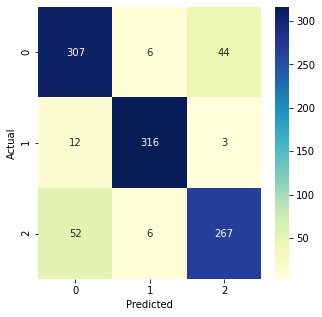

In [54]:
from sklearn.metrics import confusion_matrix
print("                     Support Vector Method - BOW")
conf_mat = confusion_matrix(y_test, y_pred2)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="YlGnBu",
            xticklabels=category_id_df.Label.values, yticklabels=category_id_df.Label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### SVM - BOW - Precision, Recall and F1-Score to quantify the quality of our model using a confusion matrix.

In [55]:
results2 = confusion_matrix(y_test, y_pred2)
print ('Confusion Matrix :')
print(results2) 
print ('Accuracy Score :',accuracy_score(y_test, y_pred2))
print ('Report : ')
print (classification_report(y_test, y_pred2))

Confusion Matrix :
[[307   6  44]
 [ 12 316   3]
 [ 52   6 267]]
Accuracy Score : 0.87857847976308
Report : 
              precision    recall  f1-score   support

           0       0.83      0.86      0.84       357
           1       0.96      0.95      0.96       331
           2       0.85      0.82      0.84       325

    accuracy                           0.88      1013
   macro avg       0.88      0.88      0.88      1013
weighted avg       0.88      0.88      0.88      1013



### SVM with BOW kfold

In [56]:
# KFold cross-validation
kFold = 10

scores = []
#To get accuracy of the model for 10 different splits
scoreValue = cross_val_score(model2, features1, labels, scoring='accuracy', cv= kFold)

# append name and score of each model with different splits
print("Random Forest with BOW: ")
for fold_idx, accuracy in enumerate(scoreValue):
    print ((fold_idx + 1), accuracy)
    scores.append(accuracy)
    
Mean_score =  sum(scores) / len(scores)
print(f" Average Accuracy : {Mean_score}" )

Random Forest with BOW: 
1 0.8825271470878578
2 0.8696939782823297
3 0.861796643632774
4 0.8675889328063241
5 0.8824110671936759
6 0.8507905138339921
7 0.8873517786561265
8 0.8824110671936759
9 0.8794466403162056
10 0.8853754940711462
 Average Accuracy : 0.8749393263074108


### Reference

[1] Multi-Class Text Classification with Scikit-Learn by Susan Li

[2] Scikit-Learn Documentation https://scikit-learn.org/